# GANS


I want to understand GANS so I can use to to data augmentation on tabular data or spot bad predictions.

**GOAL:** 
    
1. Understand GANS big picture 
1. How to initialze the DNNs
1. Why to use binary cross entropy loss
1. Simple explanation
1. Have tensorflow code

refs:

* https://debuggercafe.com/introduction-to-generative-adversarial-networks-gans/ <== looks good
    * https://debuggercafe.com/vanilla-gan-pytorch/ <== short version
* https://towardsdatascience.com/gans-generative-adversarial-networks-an-advanced-solution-for-data-generation-2ac9756a8a99
* https://towardsdatascience.com/fundamentals-of-generative-adversarial-networks-b7ca8c34f0bc#:~:text=What%20are%20GANs%2C%20and%20what,photos%20of%20more%20handwritten%20digits.
* https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29
* https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
* https://arxiv.org/pdf/1406.2661.pdf <== paper
*  https://mafda.medium.com/gans-generative-adversarial-network-with-mnist-part-db8b9c061de0
* https://www.safwan.xyz/Vanilla-GAN/ <= with the algo in pseud code


* NOTE: list of todos
* DONE: ~~understand the sparse categorical loss equation. ~~
     1. ~~Implement it using numpy.Softmax, categorical and sparse categorical cross entropy~~
     1. ~~Run some examples~~ ok
     1. ~~show the lead to same reulst and the diff is the label format~~
     1. ~~prove categorcal cross entropy = softmax + cross entropy loss~~
     1. see: https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
             https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
             https://gombru.github.io/2018/05/23/cross_entropy_loss/  <== looks good 
             https://stackoverflow.com/questions/59787897/how-does-tensorflow-sparsecategoricalcrossentropy-work

* TODO: move the sparse categorical loss learnings to another nb and refactor the code

* TODO: Inspecting the discriminator predictions for fake and real image to understand why 11 instead of 10 output

* TODO: In training, change np.full(10) -> np.full(11) np.full(0) to see if the dnn still learns



* TODO: Test the code by using batchnormalization your way (that yiou believe is right) and also remove dropout. 
But it is very interesting that is working

* TODO: Break the code 
     a) generator is much simople than discriminator
     b) discriminator is simple
     c) both are simple
     d) lr is big 

In [21]:
!hostname 
!ls

ds-vm-leandro2
2018-06-08-lhof-running_gmm_em_code_from_mcdickenson.ipynb
2018-06-18-lhof-simulated_data.ipynb
2021-10-31-lhof-study_learning_rate_finder.ipynb
2023-02-10-lhof-study_GANS.ipynb
intro_KNN.ipynb
intro_batch_normalization.ipynb
intro_gradient_algos.ipynb
intro_kmeans.ipynb
intro_pca.ipynb
intro_plda.ipynb
intro_reinforcement_learning.ipynb
intro_to_prediction_interval.ipynb
machine_learning_metrics.ipynb


# Intro

A Generative Adversarial Network (GAN) is a deep learning technique used for generating new data similar to existing data. It consists of two neural networks:

1. Generator: The generator goal is to learn how to generate sysnthectic data. We say the generator learns the data distribution
1. Discriminator: The discriminator goals is to distinguish between real data and the synsthetic data


The NN are trained in a way that the Generator try to fools the Discriminator to label the data produced by the Generator as real (zero-sum game). The Discriminator tries to correctly label the Generator output as fake (synthetic data). At the begining of training both NN commit a lot of error since they are still learning. But up to certain point, the quality of the output of the Generator increase and also the Discriminator becomes better and hard to be fooled.

GANs has many applications in the industry:
1. Image, Video and audio generations: application on social media, advertisemenst and entertainment industry. Widely used i social media
1. Data augmentation: Help training other MAchine learnings models. Many task that utilizes GANs for increase the the data size of the minority classes acheive SOTA performance. Ex:
    * CIFAR-10: paper "Improved Training of Wasserstein GANs," Arjovsky et al. (2017) and "BigGAN: Large Scale GAN Training for High Fidelity Natural Image Synthesis," Brock et al. (2018) 
    * Medical imaging: "Adversarial deep structured nets for mass segmentation from mammograms" by Li et al. (2019), Synthesizing medical images for augmented reality training data using generative adversarial networks" by Yang et al. (2018)  and "Improving medical image segmentation via adversarial training and perceptual similarity metrics" by Zhang et al. (2018)
1. Anomaly detection: Achieve SOTA performance 
    * Credit Card Fraud Detection
    * paper "Generating Synthetic Tabular Data using Generative Adversarial Networks," Wang et al. (2019) 



In the figure below is an example of GANS archictectur for generating handwritten digits using the public mnist digit database 

* It is reccomended that the input noisy size matches images sizes
    * Smaller: the generator may not have enough information to create a high-quality image
    * Larger: he generator may have too much information, leading to overfitting and producing similar images repeatedly
    

* Generator and Discrminator DNN size
    * relative size and complexity of the generator and discriminator can affect the performance and stability of the GAN.
    * discriminator is much larger and more complex than the generator, it may be able to easily identify and reject the generated samples. This result in the generator failing to learn and producing low-quality samples
    * if the generator is much larger and more complex than the discriminator, it may be able to generate realistic-looking samples that can fool the discriminator, but at the cost of requiring more training time and computational resources.


<img src="../images/gans.png" alt="GANS">

During training, GANs alternate between updating the discriminator to better distinguish real from generated images, and updating the generator to produce more realistic images that fool the discriminator.
The discriminator and generators have different losses (Because they are performing different tasks). The classifier nature of the discriminator impose loss related to binary classification or multiclass classifications while the generator  has a special loss that takes the discriminator predictions into account. Usually, discriminator loss decreases rapidly compared to the generator and then generator catch ups. The discriminator loss increases (not mandatory) at the end keep stable.

* GANS loss:

$
L_{GAN}(G,D) = E_{x \sim p_{data}(x)}[\log D(x)] + E_{z \sim p_z(z)}[\log(1-D(G(z))]
$


where:
* $G$ is the generator and $D$ is the discriminator
* $G(z)$ is the generator output (fake image)
* $x$ is real data (real image) drawn from the true data distribution $p_{data}$ ($x \sim p_{data}$)
* $z$ is random noise data drawn from a **prior** distribution $p_z$ ($z \sim p_z$)
* $E$ is the expectation operaor ("The mean")

Bellow is a discussion of the equation above. It is the **GANS loss big picture equation**:

$
L(G, D) = E_x[log(D(x))] + E_z[log(1 - D(G(z)))]
$

where:
* $G$ is the generator and $D$ is the discriminator 
* $x$ is the true images 
* $z$ is noise data for generating fake images
* $E$ is the expectation operator ("The mean")

The first term $ E_x[log(D(x))]$ is related to the probability of the discriminator (log-likelihood of the discriminator) detect an image is true given the image is real. Training find the parameters of the discriminator that maximize that term. The discriminator is encouraged to maximize the probablity of detected real images. 

The second term is related to the ability of the generator to foo the discriminator (log-likelihood of the discriminator incorrectly classifying a fake image as true). **Maximize** that ability of the generator ecncourage the generator creates more realistic images to foo the discriminator. This is the same of **minimize** the probability of be detected by the discriminator (the probability that the discriminator correctly classifies generated samples as fake).

Training is performed in  2 stages

1. All layers are trainable. This mean both discriminator and generator parmeters will be changing in order to maximize the loss function above. 

1. Only genrators layers are trainable. This mean only generators parameters will be modified by back propagation and the gradient descent in order to maximize the loss above and the first term will remain constant. Note that it is equivalent of minimize $D(G(z)$. **The generators learn twice as fast than the discriminator** for each iteration.


The choice of prior distribution can have a significant impact on the quality and diversity of the generated samples. Using a non-uniform prior distribution, such as a normal distribution ($z \sim N(0,1)$), is that it can help the generator to focus on specific regions of the data distribution where the most important features are located. For example, if the data distribution has a specific shape or structure, the prior distribution can be designed to reflect this structure and guide the generator to generate more realistic samples.Most common common priori distribution is the uniform $z \sim U(0,1)$, but different authors use: Normal, Bernouli, Multivariate Normal Distribution and Laplacian Distribution. 




# Load requirements

In [22]:
import IPython
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image

InteractiveShell.ast_node_interactivity = "all"
print("agor vai")

# import nbformat
# from nbformat import v4

agor vai


In [23]:
import tensorflow as tf
from keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

```sh
pip install nbformat
```

In [24]:
# # save the current notebook
# nb = v4.new_notebook()
# nbformat.write(nb, open('2023-02-10-lhof-study_GANS-v1.ipynb', 'w'), version=4)

# Load data

In [25]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.0
x_train = np.expand_dims(x_train, axis=-1)

# summarize the shape of the dataset
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

Train (60000, 28, 28, 1) (60000,)
Test (10000, 28, 28) (10000,)


8

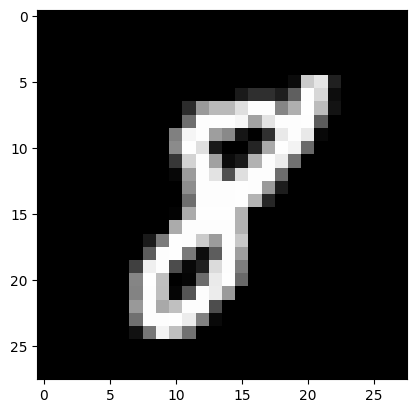

In [26]:

# plot raw pixel data
#pyplot.imshow(trainX[i], cmap='gray')
k = 17
y_train[k]
plt.imshow(x_train[k], cmap='gray')

# Discriminator

In [8]:
def discriminator_model(in_shape=(28,28,1)):

    model =  tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # compile model
    opt =  tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

discriminator = discriminator_model()

discriminator.summary()
#plot_model(discriminator, show_shapes=True, show_layer_names=True)


2023-03-02 16:36:23.792137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

# Generator 

In [9]:
def generator_model(latent_dim = 100):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_shape=(latent_dim,)),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dense(256),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dense(28 * 28 * 1, activation='tanh'),
        tf.keras.layers.Reshape((28, 28, 1))
    ])

    return model

latent_dim = 28*28
generator = generator_model(latent_dim)

# Compiling the generator
generator.compile(loss='binary_crossentropy', optimizer='adam')

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               100480    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)              

# GANS

In [10]:
discriminator.trainable = False

gans = tf.keras.Sequential([generator,discriminator])

opt =  tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
gans.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [11]:
gans.layers

gans.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         336528    
                                                                 
 sequential (Sequential)     (None, 1)                 40705     
                                                                 
Total params: 377,233
Trainable params: 335,760
Non-trainable params: 41,473
_________________________________________________________________


# Training

In [12]:
batch_size = 1024*3

real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

smooth = 0.1

i = 0
# Train Discriminator weights
discriminator.trainable = True
        
# Real samples
X_batch = x_train[i*batch_size:(i+1)*batch_size]
d_loss_real = discriminator.train_on_batch(x=X_batch, y=real)
        
# Fake Samples
z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
X_fake = generator.predict_on_batch(z)
d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
# Discriminator loss
d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
# Train Generator weights
discriminator.trainable = False
d_g_loss_batch = gans.train_on_batch(x=z, y=real)

print("Finish him")

Finish him


In [15]:
def train_gan(gan, discriminator, generator, x_train, epochs=30, batch_size=64, latent_dim=100):

    history = {'discriminator': {'loss': [], 'accuracy': []}, 'generator': {'loss': [], 'accuracy': []}}
    for epoch in range(epochs):
        
        for i in range(x_train.shape[0] // batch_size):

            # Select a random batch of images
            idxs  = np.random.randint(low=0,high=x_train.shape[0],size=batch_size)
            real_images = x_train[idxs]
            
            # Generate fake images
            noise = np.random.normal(0, 1,size=[batch_size, latent_dim])
            fake_images = generator.predict(noise,verbose=False)
            
            # Combine real and fake images
            x = np.concatenate([real_images, fake_images])
            
            # Labels for real and fake images
            y = np.ones(2 * batch_size)
            y[batch_size:] = 0
            
            # Train the discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(x, y)
            
            # Train the generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            y = np.ones(batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y)

        if epoch % 50 == 0:
            samples = 3
            # Generate fake images to visualize progress
            noise = np.random.normal(0, 1, (samples, latent_dim))
            fake_images = generator.predict(noise,verbose=False)

            # Plot the fake images
            plt.figure(figsize=(10, 10))
            for i in range(samples):
                plt.subplot(1, samples, i + 1)
                plt.imshow(fake_images[i, :, :, 0], cmap='gray')
                plt.axis('off')
        
        # Save the losses and accuracies
        history['discriminator']['loss'].append(d_loss[0])
        history['discriminator']['accuracy'].append(d_loss[1])
        history['generator']['loss'].append(g_loss[0])
        history['generator']['accuracy'].append(g_loss[1])

        
        if epoch % 25 == 0:
            # Print the progress
            print("Epoch:", epoch + 1, 
                f"Generator Loss: {g_loss[0]:.4f}", f"Generator Accuracy: {g_loss[1]:.1%}", 
                f"Discriminator Loss: {d_loss[0]:.4f}", f"Discriminator Accuracy: {d_loss[1]:.1%}")

    return history


In [16]:
batch_size
x_train.shape
x_train.shape[0]//batch_size


3072

(60000, 28, 28, 1)

19

Epoch: 1 Generator Loss: 1.7354 Generator Accuracy: 0.0% Discriminator Loss: 0.3866 Discriminator Accuracy: 93.1%
CPU times: user 58min 5s, sys: 3min 38s, total: 1h 1min 43s
Wall time: 12min 17s


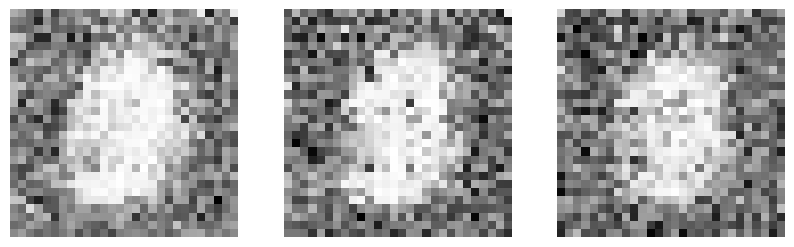

In [19]:
%%time
# Training the GAN
#train_gan(generator, discriminator, x_train)

# Tooke 12m for 25 epochs. (I need to run in cloud)
history = train_gan(gans, discriminator, generator, x_train, epochs=25, batch_size=batch_size, latent_dim=latent_dim)

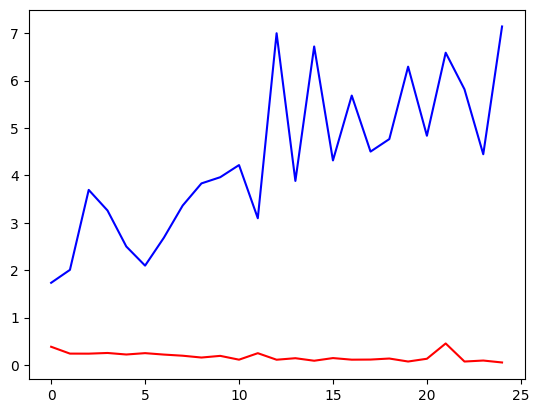

In [20]:
plt.plot(history['discriminator']['loss'], 'r')
plt.plot(history['generator']['loss'], 'b')

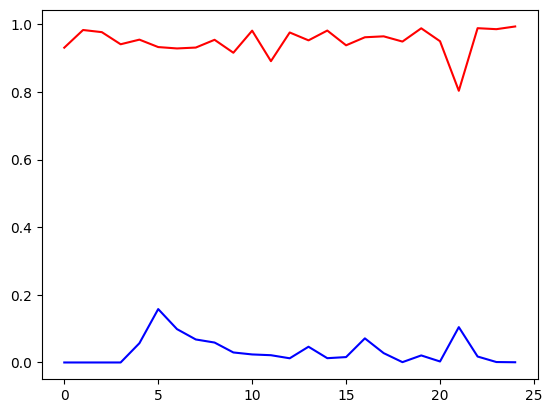

In [21]:
plt.plot(history['discriminator']['accuracy'], 'r')
plt.plot(history['generator']['accuracy'], 'b')

<Figure size 1000x1000 with 0 Axes>

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

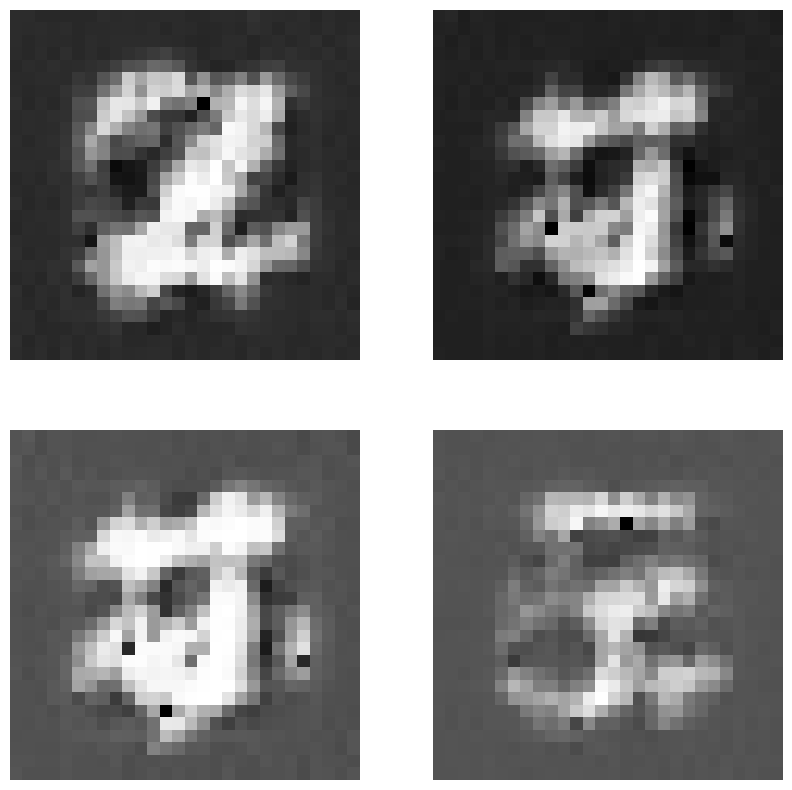

In [22]:
n_col = 2
n_row = 2
samples = n_col + n_row
# Generate fake images to visualize progress
noise = np.random.normal(0, 1, (samples, latent_dim))
fake_images = generator.predict(noise,verbose=False)

# Plot the fake images
plt.figure(figsize=(10, 10))
for i in range(samples):
    plt.subplot(n_row,n_col, i + 1)
    plt.imshow(fake_images[i, :, :, 0], cmap='gray')
    plt.axis('off')


# Change the archictecture to be able to select the digit

https://www.kaggle.com/code/zhoulingyan0228/generating-mnist-gan


**PAREI**
* PRECISO EMNTENDER A ARQUITETURA** 
    * alterar batchnormalization depois de activation
    * remover dropout com bacthnormalization (talvez se for usado em layers diferentes eh ok)

In [29]:
from tensorflow.keras.layers import Input, Embedding, concatenate, Dense, Reshape, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, UpSampling2D, Conv2D,Activation

from tensorflow.keras.models import Model

In [27]:
def random_mnist_set(X, y, size=10):
    
    length = len(X)
    indices = np.random.choice(length, size)
    
    return X[indices], y[indices]

def random_generated_set(generator, size=10):
    
    # z
    latents = np.random.normal(0, 1, (size, latent_dim))
    
    return generator.predict_on_batch({'latent_input':latents,
                      'label_input':np.random.randint(10, size=size)})

(1, 28, 28, 1)

(1,)

array([7], dtype=uint8)

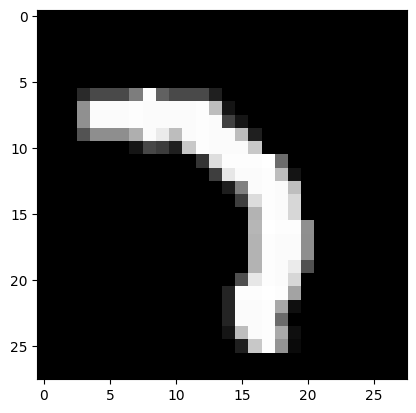

In [31]:
X = x_train
y = y_train

X_i, y_i = random_mnist_set(X, y, 1)

X_i.shape
y_i.shape

y_i
plt.imshow(X_i[0,:,:,0], cmap='gray')

In [7]:
def generator_model(latent_dim = 100):
    
         
    latent_input = Input(shape=(latent_dim,), name='latent_input')
    
    label_input = Input(shape=(1,), name='label_input') # 0...9
    x = Embedding(input_dim=10, output_dim=10)(label_input)
    x = Reshape((10,))(x)
    
    x = concatenate([x, latent_input], axis=-1)

    x = Dense(7*7*128)(x)
    x = LeakyReLU()(x)
    x = Reshape((7,7,128))(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    x = Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
    x = Activation('sigmoid')(x)
    x = Reshape((28,28,))(x)
    
    model = Model(inputs=[latent_input, label_input], outputs=x)

    return model

generator = generator_model()

generator.summary()

2023-03-12 06:31:18.019499: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-12 06:31:18.021251: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-12 06:31:18.021277: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ds-vm-leandro2): /proc/driver/nvidia/version does not exist
2023-03-12 06:31:18.023218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                                  
 reshape (Reshape)              (None, 10)           0           ['embedding[0][0]']              
                                                                                                  
 latent_input (InputLayer)      [(None, 100)]        0           []                               
                                                                                              

In [8]:
def discriminator_model(in_shape=(28,28,)):

    img_input = Input(shape=in_shape)
    x = Reshape((28,28,1))(img_input)
    
    x = Conv2D(16, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    
    # NOTE: Why outputs is 11 and not 10
    x = Dense(11, activation='softmax')(x)
    
    model = Model(inputs=img_input, outputs=x)
    
    return model

In [9]:
discriminator = discriminator_model()

discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 16)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          4640      
                                                           

In [10]:
latent_dim = 100
latent_input = Input(shape=(latent_dim,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')

x = generator([latent_input, label_input])
x = discriminator(x)

gan = Model(inputs=[latent_input, label_input], outputs=x)

discriminator.trainable = False
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_input (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 28, 28)       789221      ['latent_input[0][0]',           
                                                                  'label_input[0][0]']            
                                                                                                  
 model_1 (Functional)           (None, 11)           103755      ['model[0][0]']            

In [11]:
discriminator.trainable = True
discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], 
                      optimizer=tf.keras.optimizers.Adam(0.001))

discriminator.trainable = False
gan.compile(loss='sparse_categorical_crossentropy', metrics=['acc'],
            optimizer=tf.keras.optimizers.Adam(0.0003))

In [70]:
np.full(7, 10)
np.random.randint(10, size=3)
np.arange(10)

array([10, 10, 10, 10, 10, 10, 10])

array([7, 9, 3])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [78]:
%%time 

X = x_train
y = y_train

save_interval = 15
epochs = save_interval*10 + 1
batch_size = 20

history = {'dloss':[], 'gloss':[]}

for iteration in range(epochs):
    
    # train discriminator
    discriminator.trainable = True
    
    X_sample, y_sample = random_mnist_set(X, y, batch_size)
    dloss_real = discriminator.train_on_batch(X_sample, y_sample)
    
    # NOTE: GEt random fake image created by the generator
    fake_image = random_generated_set(generator, size=batch_size)
    # NOTE: !? Why the label is 10 and not 0
    fake_label = np.full(batch_size, 0)
    dloss_fake = discriminator.train_on_batch(fake_image, fake_label)
    
    # train generator
    # NOTE: Freeze discriminator parameters
    discriminator.trainable = False
    
    gan_labels = np.random.randint(10, size=batch_size)
    gloss = gan.train_on_batch({'latent_input':np.random.normal(0, 1, (batch_size, 100)),
                        'label_input':gan_labels}, 
                       gan_labels)
    
    history['dloss'].append((dloss_real[0]+dloss_fake[0])/2)
    history['gloss'].append(gloss[0])
    
    if iteration % save_interval == 0:
        
        print('generator: loss={}. acc={}'.format(gloss[0], gloss[1]))
        print('discriminator: loss_real={}, acc_real={}'.format(dloss_real[0],dloss_real[1]))
        print('    loss_fake={}, acc_fake={}'.format(dloss_fake[0],dloss_fake[1]))
        generator.save_weights('generator_{0:05d}.h5'.format(iteration))

generator: loss=0.11581375449895859. acc=0.949999988079071
discriminator: loss_real=0.47859472036361694, acc_real=0.949999988079071
    loss_fake=25.815820693969727, acc_fake=0.0
generator: loss=4.687718868255615. acc=0.3499999940395355
discriminator: loss_real=0.8207719922065735, acc_real=0.75
    loss_fake=0.5553551912307739, acc_fake=0.8500000238418579
generator: loss=4.212149143218994. acc=0.05000000074505806
discriminator: loss_real=0.4643482267856598, acc_real=0.8500000238418579
    loss_fake=0.2480974644422531, acc_fake=0.8999999761581421
generator: loss=5.992287635803223. acc=0.15000000596046448
discriminator: loss_real=0.231042742729187, acc_real=0.8999999761581421
    loss_fake=0.10599996149539948, acc_fake=0.949999988079071
generator: loss=3.5347657203674316. acc=0.25
discriminator: loss_real=0.6432533860206604, acc_real=0.800000011920929
    loss_fake=0.14996029436588287, acc_fake=0.949999988079071
generator: loss=2.170738458633423. acc=0.15000000596046448
discriminator: lo

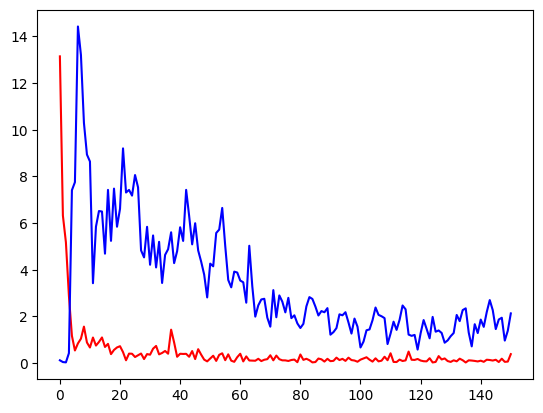

In [79]:
plt.plot(history['dloss'], 'r')
plt.plot(history['gloss'], 'b')

In [80]:
!ls *.h5

generator_00000.h5 generator_00075.h5 generator_00150.h5 generator_01500.h5
generator_00015.h5 generator_00090.h5 generator_00300.h5 generator_01800.h5
generator_00030.h5 generator_00105.h5 generator_00600.h5 generator_02100.h5
generator_00045.h5 generator_00120.h5 generator_00900.h5 generator_02400.h5
generator_00060.h5 generator_00135.h5 generator_01200.h5 generator_02700.h5


<Figure size 1000x4000 with 0 Axes>

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

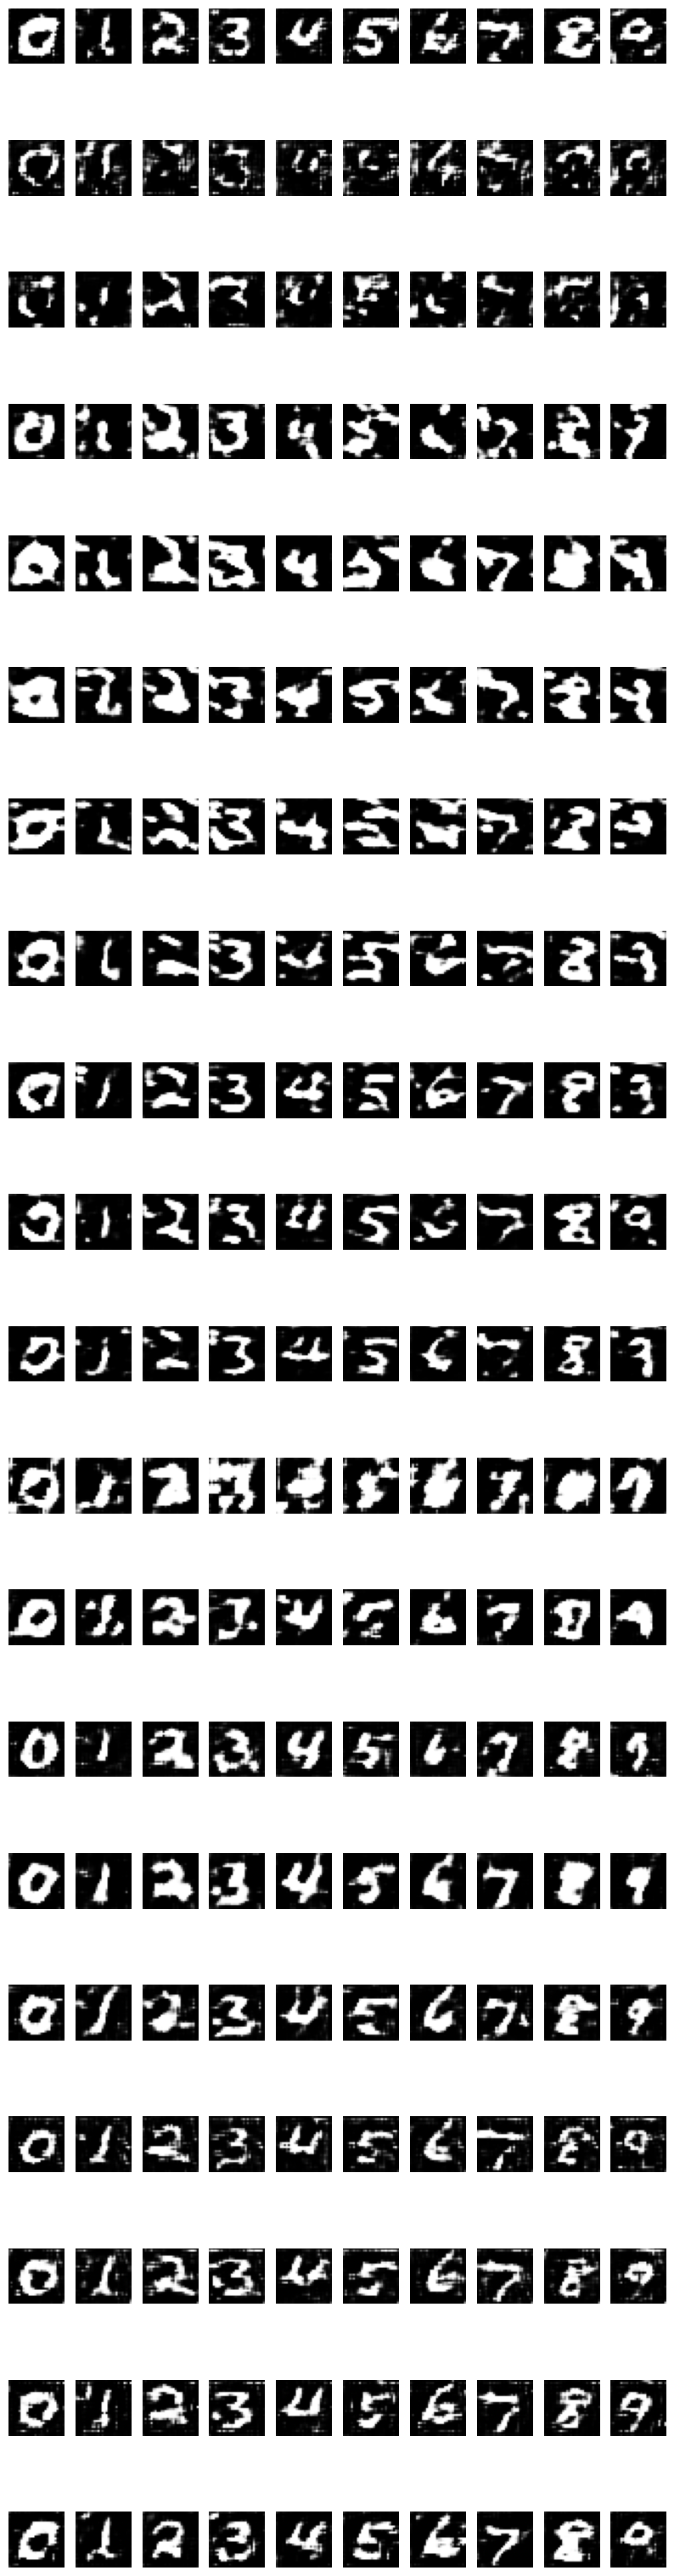

In [81]:
#import seaborn as sns
import glob

checkpoints = sorted(glob.glob('generator_*.h5'))

plt.figure(figsize=(10,2*len(checkpoints)))
for i,cp in enumerate(checkpoints):
    generator.load_weights(cp)
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')